In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.nn import tanh, softmax, relu
from tensorflow.keras import Model
from PIL import Image
import glob
import pickle
from tqdm import tqdm
import time

# Load train development and test images

In [2]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [3]:
# load all images
img = glob.glob(images+'*.jpg')

In [4]:
def split_data(txt):
    result = []
    for i in img:
        if i[len(images):] in txt:
            result.append(i)
    return result

In [5]:
# getting training images from all images
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
train_img = split_data(train_images)
len(train_img)

6000

In [6]:
# getting development images from all images
dev_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
dev_images = set(open(dev_images_file, 'r').read().strip().split('\n'))
dev_img = split_data(dev_images)
len(dev_img)

1000

In [7]:
# getting test images from all images
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = split_data(test_images)
len(test_img)

1000

In [8]:
#preprocessing is required by InceptionV3 model
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [9]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [10]:
# get InceptionV3 model from keras application
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [11]:
# the output of new model is the last layer of InceptionV3 before softmax layer
new_input = model.input
hidden_layer = model.layers[-1].output
model_new = tf.keras.Model(new_input, hidden_layer)

In [12]:
def encode(image):
    image = preprocess(image)
    result = model_new.predict(image)
    result = np.reshape(result,(result.shape[0],result.shape[1]*result.shape[2],result.shape[3]))
    return result

In [130]:
# processing all train images. The encoding_train dict saves vetor representation of all train images
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [03:49<00:00, 27.13it/s]


In [131]:
# save encoding_train dict as pickle for future use
with open("encoded_images_train.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [12]:
encoding_train = pickle.load(open('encoded_images_train.p', 'rb'))

In [133]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [00:37<00:00, 26.18it/s]


In [134]:
with open("encoded_images_test.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [13]:
encoding_test = pickle.load(open('encoded_images_test.p', 'rb'))

# load caption for train development and test set

In [14]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [15]:
captions = open(token, 'r').read().strip().split('\n')

In [16]:
# load all captions
all_captions = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in all_captions:
        all_captions[row[0]].append(row[1])
    else:
        all_captions[row[0]] = [row[1]]

In [17]:
#getting train captions from all captions
train_captions = {}
for i in train_img:
    if i[len(images):] in all_captions:
        train_captions[i] = all_captions[i[len(images):]]

In [18]:
#getting dev captions from all captions
dev_captions = {}
for i in dev_img:
    if i[len(images):] in all_captions:
        dev_captions[i] = all_captions[i[len(images):]]

In [19]:
#getting test captions from all captions
test_captions = {}
for i in test_img:
    if i[len(images):] in all_captions:
        test_captions[i] = all_captions[i[len(images):]]

In [20]:
# add '<start>', '<end>' tags for all captions
caps = []
for key, val in train_captions.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [21]:
# using keras tokenizer to creat the tokenized vectors for train captions
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(caps)
train_seqs = tokenizer.texts_to_sequences(caps)

In [22]:
# padding each vector to the max_length of the captions
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(caps)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [23]:
# get the length of longest caption
max_length = max(len(t) for t in cap_vector)

# Create dataset for trainning

In [24]:
# create dataset for training
x_train = []
y_train = []
i = 0
for key, val in train_captions.items():
    for v in val:
        image = encoding_train[key[len(images):]].reshape(64,2048)
        x_train.append(image)
        cap = cap_vector[i]
        y_train.append(cap)
        i = i+1

In [25]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [26]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(1000).batch(16)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define model

In [27]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
features_shape = 2048
BATCH_SIZE = 16
num_steps = 30000 // BATCH_SIZE

In [ ]:
# follow the tensorflow 2.0 tourtial (https://www.tensorflow.org/alpha/tutorials/quickstart/advanced)

In [28]:
class Attention(Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, features, hidden):
    hidden = tf.expand_dims(hidden, 1)
    score = tanh(self.W1(features) + self.W2(hidden))
    attention_weights = softmax(self.V(score), axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [29]:
class CNN_Encoder(Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = relu(x)
        return x

In [30]:
class RNN_Decoder(Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = Dense(self.units)
    self.fc2 = Dense(vocab_size)
    self.attention = Attention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    output, _ ,state = self.lstm(x)

    x = self.fc1(output)
    x = tf.reshape(x, (x.shape[0]*x.shape[1], x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [31]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# encoder.load_weights('./checkpoints/encoder_checkpoint')
# decoder.load_weights('./checkpoints/decoder_checkpoint')

W0518 00:38:42.942625 139806275188544 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f25a014ca20>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [32]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# loss_function should ignore <tap>
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [33]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
        
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [35]:
EPOCHS = 5

for epoch in range(EPOCHS):
    batch = 0
    start = time.time()
    total_loss = 0
    for (img_tensor, target) in  train_ds: 
        batch = batch + 1
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    

Epoch 1 Batch 100 Loss 0.7203
Epoch 1 Batch 200 Loss 0.6611
Epoch 1 Batch 300 Loss 0.6562
Epoch 1 Batch 400 Loss 0.6139
Epoch 1 Batch 500 Loss 0.7338
Epoch 1 Batch 600 Loss 0.6936
Epoch 1 Batch 700 Loss 0.5873
Epoch 1 Batch 800 Loss 0.4632
Epoch 1 Batch 900 Loss 0.6432
Epoch 1 Batch 1000 Loss 0.6560
Epoch 1 Batch 1100 Loss 0.7356
Epoch 1 Batch 1200 Loss 0.5901
Epoch 1 Batch 1300 Loss 0.7660
Epoch 1 Batch 1400 Loss 0.5155
Epoch 1 Batch 1500 Loss 0.6907
Epoch 1 Batch 1600 Loss 0.6717
Epoch 1 Batch 1700 Loss 0.7607
Epoch 1 Batch 1800 Loss 0.5889
Epoch 1 Loss 0.686328
Time taken for 1 epoch 339.3377664089203 sec

Epoch 2 Batch 100 Loss 0.6554
Epoch 2 Batch 200 Loss 0.6170
Epoch 2 Batch 300 Loss 0.5920
Epoch 2 Batch 400 Loss 0.5884
Epoch 2 Batch 500 Loss 0.6875
Epoch 2 Batch 600 Loss 0.6526
Epoch 2 Batch 700 Loss 0.5641
Epoch 2 Batch 800 Loss 0.4199
Epoch 2 Batch 900 Loss 0.6031
Epoch 2 Batch 1000 Loss 0.6087
Epoch 2 Batch 1100 Loss 0.7284
Epoch 2 Batch 1200 Loss 0.5755
Epoch 2 Batch 1300 L

In [67]:
encoder.save_weights('./checkpoints/encoder_checkpoint')
decoder.save_weights('./checkpoints/decoder_checkpoint')

In [68]:
def test():
    test_n = np.random.randint(0, 1000)
    test = encoding_test[test_img[test_n][len(images):]].reshape(64,2048)
    for c in test_captions[test_img[test_n]]:
        print (c)
    features = encoder(test)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    attention_plot = np.zeros((max_length, 64))
    hidden = decoder.reset_state(batch_size=1)
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            break

        dec_input = tf.expand_dims([predicted_id], 0)
    print (result)
    return test_n

A group of 6 boys are wearing yellow life vests and are on a make-shift raft .
A group of people on a boat .
Boys in life jackets on a watercraft .
Several young people in life jackets are sitting on something floating in water .
The boys in life jackets smile and laugh while riding in a boat .
['two', 'people', 'in', 'life', 'jackets', 'sitting', 'on', 'the', 'water', '<end>']


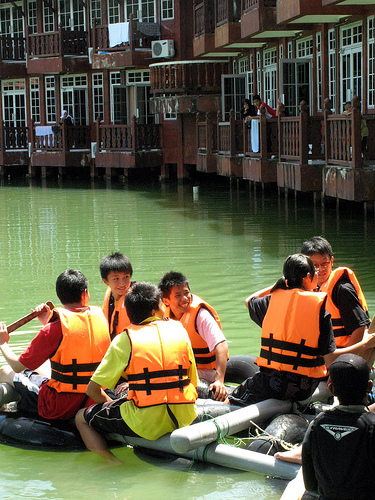

In [69]:
 Image.open(test_img[test()])

A dog runs along a forest lane .
A pale dog is running along a dirt path .
A shaggy dog runs down a dirt trail in a lush forest .
A white and brown shaggy dog is running down a dirt path in a park .
The curly haired white dog is running down a wooded path .
['a', 'tan', 'dog', 'is', 'running', 'in', 'a', 'forest', '<end>']


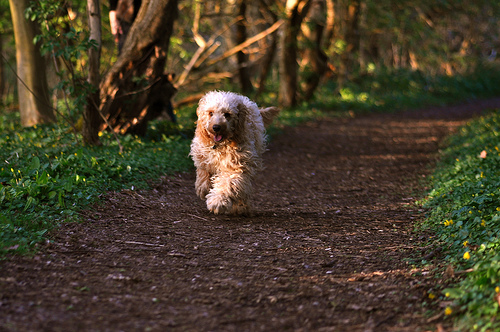

In [75]:
 Image.open(test_img[test()])

A beagle walks through the grass .
A black and tan dog standing in a field near trees
A brown and tan dog walks through the green grass .
a smal hound dog walking through the grass outside .
The dog is walking through a grassy area .
['a', 'dog', 'is', 'running', 'in', 'the', 'grass', '<end>']


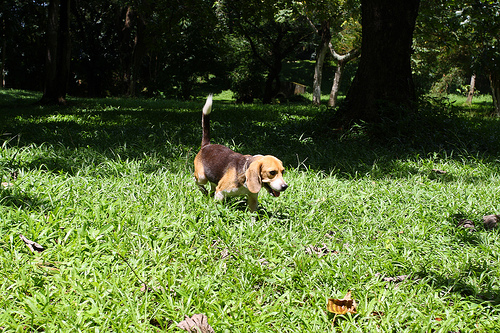

In [80]:
 Image.open(test_img[test()])

A brown dog leaps into the water .
A dog leaping off a boat
A dog wearing a collar jumping from a platform .
a grey and brown dog jumps off a dock into a lake
A light brown dog with his tail in the air jumps of a pontoon toward the water .
['a', 'brown', 'dog', 'is', 'biting', 'a', 'second', 'dog', '<end>']


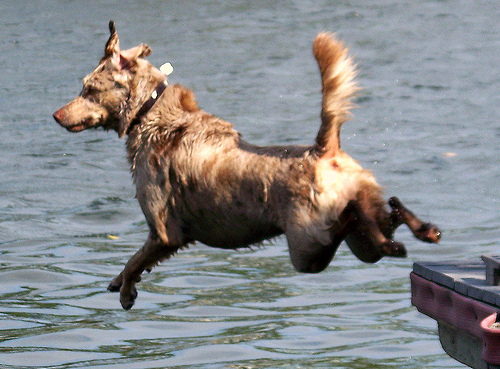

In [89]:
 Image.open(test_img[test()])

In [ ]:
 Image.open(test_img[test()])

In [ ]:
 Image.open(test_img[test()])